In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from scipy.stats import expon
from utils import *


In [16]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    good_dict = {}

    for key in keys:

        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        # timeLimit = mergedConfigs["sim-time-limit"]

        
        # assert timeLimit.endswith('s'), "Time limit format is incorrect"
        # timeLimit = timeLimit[:-1]  # Remove the 's' at the end

        good_dict[measurement]={}
        good_dict[measurement]['measurement']=measurement
        good_dict[measurement]['parameters']=dict(item.split("=") for item in measurement.split(", "))
        good_dict[measurement]['param']={a['name']: a['value'] for a in data[key]['parameters']}
        good_dict[measurement]['scalars']={a['name']: a['value'] for a in data[key]['scalars']}
        good_dict[measurement]['repetition']=int(repetition)
        # good_dict[measurement]['timeLimit']=int(timeLimit)
        good_dict[measurement]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in good_dict[measurement]['modules']:
                good_dict[measurement]['modules'][module] = {}

            good_dict[measurement]['modules'][module][name] = {}
            good_dict[measurement]['modules'][module][name]["times"] = a["time"][:]
            good_dict[measurement]['modules'][module][name]["values"] = a["value"][:]





    return good_dict


good_dict = importData("../multicore_sched/simulations/test.json")

In [17]:
#print keys of good_dict one under another
for key in good_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDurati

In [18]:
filter={
    "$pCpuBound"                : None,
    "$rho"                      : None,
    "$meanProcessDuration"       : '100ms',
    "$numCpus"                  : None,
    "$generationType"           : '"exponential"',
    "$durationType"             : '"exponential"',
    "$isFCFS"                   : 'false'
}

In [19]:
rhoSmall='0.5'
rhoBig='0.8'

In [20]:
rhoStrings=[f"ρ = {rhoSmall}",f"ρ = {rhoBig}"]
colors1=['#1F77B4','#FF7F0E']
colors2=['#FF00FF','#FF0000']

In [21]:
filtered_dict={}
filtered_dict_rho={}
filtered_array_rho=[]


for key, value in good_dict.items():
    key_dict = dict(item.split("=") for item in key.split(", "))
    match = True
    for f_key, f_value in filter.items():
        if f_value is None:
            continue
        if key_dict.get(f_key) != f_value:
            break
    else:
        filtered_dict[key] = value

        parametersNoRho = key_dict.copy()
        rhoPos= rhoBig == parametersNoRho["$rho"]
        parametersNoRho.pop("$rho", None)
        parametersNoRhoString=str(parametersNoRho)

        if parametersNoRhoString not in filtered_dict_rho:
            filtered_dict_rho[parametersNoRhoString]=[{},{}]
        
        filtered_dict_rho[parametersNoRhoString][rhoPos] = value.copy()

#convert filtered_dict_rho to array
for key, value in filtered_dict_rho.items():
    filtered_array_rho.append(value)

# print(filtered_dict.keys())
for key in filtered_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.9, $rho=0.8, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.9, $

In [22]:
statistic='numBusyCpus:vector'

In [23]:
testToUse=list(filtered_dict.keys())[0]
values = filtered_dict[testToUse]['modules']["Computer.scheduler"][statistic]["values"]

In [24]:
def getMeasurement(axs,measurement):
    x=0
    y=0
    if "$numCpus=12" in measurement:
        x+=1
    if "$pCpuBound=0.9" in measurement:
        y=1

    # Format measurent = "$pCpuBound=0.1, $meanGenerationTime=30ms, $rho=0.4, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false"
    # to pCpuBound=0.1, numCpus=4
    parts = measurement.split(", ")

    pCpuBound = next(part for part in parts if "pCpuBound" in part)[1:]
    numCpus = next(part for part in parts if "numCpus" in part)[1:]

    measurementString = f"{pCpuBound}, {numCpus}"
    
    rhoVal = next(part for part in parts if "rho" in part).split("=")[1]

    return axs[x][y],measurementString

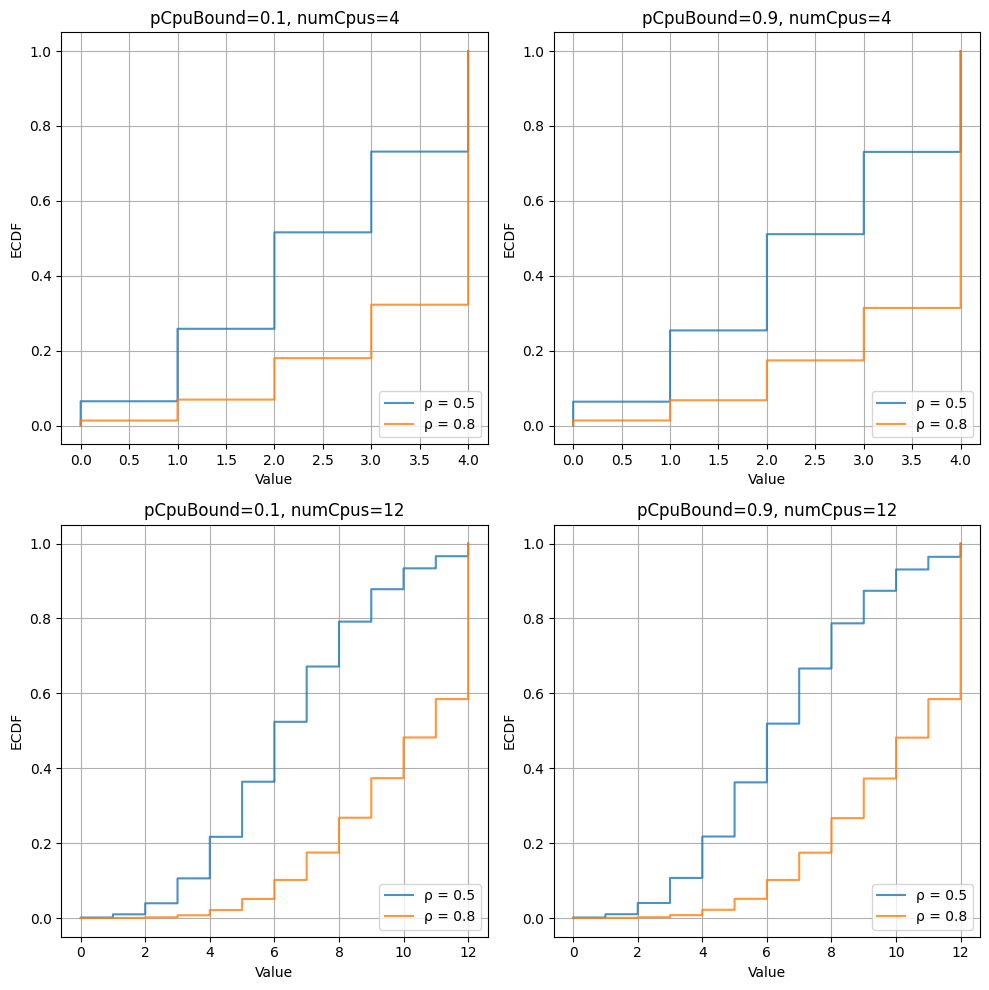

In [25]:
from statsmodels.distributions.empirical_distribution import ECDF

#for each element in filtered_array plt ecdf of statistic
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

maxXDict={}

xFin={
    '4':2.6,
    '12':2
}

for i, element in enumerate(filtered_array_rho):

    maxX=0
    
    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        ecdf = ECDF(values)

        # Extend ECDF to the right

        if ecdf.x[-1] > maxX:
            maxX = ecdf.x[-1]

        x=xFin[elementRho['parameters']['$numCpus']]

        ax,measurementString = getMeasurement(axs, measurement)
        ax.step(ecdf.x, ecdf.y, label=rhoStrings[rhoNum],alpha=0.8,color=colors1[rhoNum])
        # ax.set_title(f"ECDF of {measurement}")
    
    x=xFin[element[0]['parameters']['$numCpus']]

    # ax.set_xlim(-0.1,x)

    # ax.set_ylim(0, 1)
    ax.set_xlabel('Value')
    ax.set_ylabel('ECDF')
    ax.set_title(f'{measurementString}')
    ax.legend(loc='lower right')
    ax.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# import copy
# filtered_array_rho_iid=[]


# for i, element in enumerate(filtered_array_rho):

#     filtered_array_rho_iid.append([{},{}])

#     for rhoNum, elementRho in enumerate(element):

#         values = elementRho['modules']["Computer.scheduler"][statistic]["values"].copy()

#         print(len(values))

#         values = makeValuesIndependent(values)

#         filtered_array_rho_iid[i][rhoNum] = copy.deepcopy(elementRho)

#         filtered_array_rho_iid[i][rhoNum]['modules']["Computer.scheduler"][statistic]["values"]=values.copy()


In [29]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap

# Initialize a dictionary to store results
data_dict = {}

for i, element in enumerate(filtered_array_rho):
    for rhoNum, elementRho in enumerate(element):
        try:
            values = np.array(elementRho['modules']["Computer.scheduler"][statistic]["values"])
            times = np.array(elementRho['modules']["Computer.scheduler"][statistic]["times"])
            measurement = elementRho['measurement']


            weights = [times[i+1]-times[i] for i in range(len(times)-1)]
            values=values[:-1]
            mean,stdDev=weighted_avg_and_std(values,weights)

            ax, measurementString = getMeasurement(axs, measurement)

            rhoString = rhoStrings[rhoNum]

            numCpus = f'numCpus = {elementRho["parameters"]["$numCpus"]}'

            pCpuBound = f'pCpuBound = {elementRho["parameters"]["$pCpuBound"]}'

            # # Organize data into dictionary format
            # if measurementString not in data_dict:
            #     data_dict[measurementString] = {}
            # if rhoString not in data_dict[measurementString]:
            #     data_dict[measurementString][rhoString] = {}

            # Organize data into dictionary format
            if numCpus not in data_dict:
                data_dict[numCpus] = {}
            if pCpuBound not in data_dict[numCpus]:
                data_dict[numCpus][pCpuBound] = {}
            if rhoString not in data_dict[numCpus][pCpuBound]:
                data_dict[numCpus][pCpuBound][rhoString] = {}

            data_dict[numCpus][pCpuBound][rhoString] = {
                ('Mean', 'Value'): mean,
                ('Std Dev', 'Value'): stdDev,
            }


        except KeyError as e:
            print(f"KeyError encountered: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

# Convert the nested dictionary into a properly structured DataFrame
df_results = pd.DataFrame.from_dict(
    {(numCpu,pCpuBound, rho): values for numCpu, pCpuBounds in data_dict.items() for pCpuBound, rhos in pCpuBounds.items() for rho, values in rhos.items()},
    orient='index'
)

# Set the column names as MultiIndex
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns, names=['Metric', 'Statistic'])

# **Transpose the DataFrame to invert rows and columns**
df_results = df_results.T

# Display the DataFrame
display(df_results)


numCpus = 4                                      \
                  pCpuBound = 0.1           pCpuBound = 0.9             
                          ρ = 0.5   ρ = 0.8         ρ = 0.5   ρ = 0.8   
Metric  Statistic                                                       
Mean    Value            2.019525  3.215061        2.029782  3.224600   
Std Dev Value            1.294477  1.127088        1.293871  1.126852   

                     numCpus = 12                                      
                  pCpuBound = 0.1           pCpuBound = 0.9            
                          ρ = 0.5   ρ = 0.8         ρ = 0.5   ρ = 0.8  
Metric  Statistic                                                      
Mean    Value            6.005046  9.616648        6.026878  9.606854  
Std Dev Value            2.426387  2.448172        2.450393  2.457612

In [28]:
# import numpy as np
# from scipy.stats import bootstrap

# def weighted_mean(data, weights):
#     """Compute the weighted mean."""
#     return np.sum(data)

# def bootstrap_weighted_mean_CI(data, weights, B=10, ci=0.95, random_state=None):
#     """
#     Compute confidence interval for the weighted mean using bootstrap and importance resampling.
    
#     Parameters:
#         data (array-like): Sample data points.
#         weights (array-like): Corresponding weights.
#         B (int): Number of bootstrap resamples.
#         ci (float): Confidence level (default=0.95).
#         random_state (int, optional): Random seed for reproducibility.
    
#     Returns:
#         tuple: (lower_bound, upper_bound) of the confidence interval.
#     """
#     np.random.seed(random_state)
    
#     # Convert to numpy arrays
#     data = np.array(data)
#     weights = np.array(weights)
    
#     # Normalize weights to sum to 1 (probabilities for importance sampling)
#     probabilities = weights / np.sum(weights)
    
#     # Generate bootstrap resamples using importance resampling
#     resamples = np.random.choice(data, size=(B, len(data)), replace=True, p=probabilities)

#     print(resamples)
    
#     # Define statistic function for bootstrap
#     def stat_func(samples, axis):
#         return np.mean(samples, axis=axis)  # Since we already resampled with weights

#     # Compute bootstrap confidence interval
#     boot_result = bootstrap(
#         (resamples,),  # Data must be in a tuple
#         stat_func,
#         confidence_level=ci,
#         method="percentile",  # 'basic' or 'BCa' could also be used
#         axis=1,
#         n_resamples=999
#     )

#     return boot_result.confidence_interval.low, boot_result.confidence_interval.high

# # Example Usage
# data = np.array([10, 20, 30, 40, 50])  # Example data
# weights = np.array([1, 1, 0, 0, 0])    # Example weights

# ci_lower, ci_upper = bootstrap_weighted_mean_CI(data, weights)
# # print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")
# print(ci_lower, ci_upper)